In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [1]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
print(Base.classes.keys())

['measurement', 'station']


In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()

print(f"The most recent date in the dataset is: {most_recent_date}")

The most recent date in the dataset is: 2017-08-23


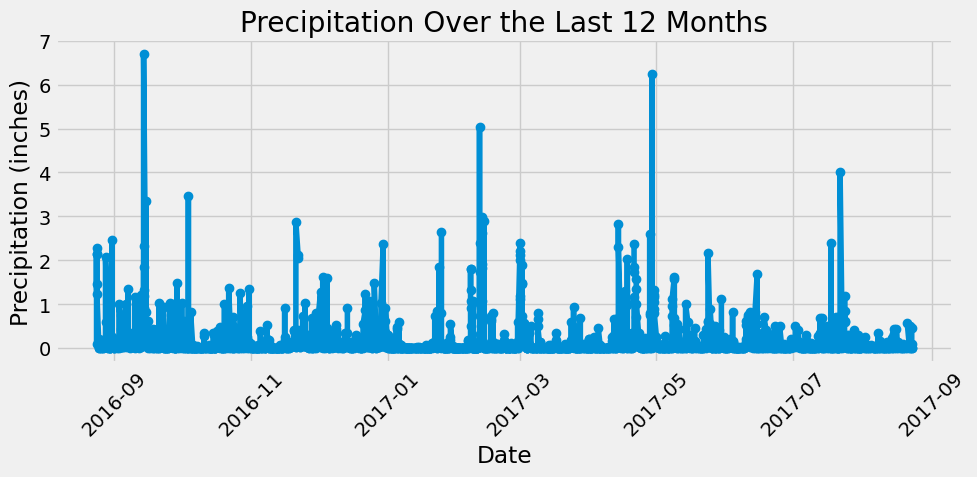

In [13]:


# Find the most recent date
most_recent_date = session.query(func.max(Measurement.date)).scalar()

# Step 2: Calculate the date one year from the last date
one_year_ago = datetime.strptime(most_recent_date, '%Y-%m-%d') - timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

# Step 4: Save the query results as a Pandas DataFrame
precipitation_df = pd.DataFrame(precipitation_data, columns=['date', 'precipitation'])

# Step 5: Sort the DataFrame by date (already sorted in the query, but just in case)
precipitation_df['date'] = pd.to_datetime(precipitation_df['date'])
precipitation_df.sort_values('date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 5))
plt.plot(precipitation_df['date'], precipitation_df['precipitation'], marker='o', linestyle='-')
plt.title('Precipitation Over the Last 12 Months')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [14]:
# Calculate summary statistics for the precipitation data
summary_statistics = precipitation_df['precipitation'].describe()

# Print the summary statistics
print(summary_statistics)


count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64


# Exploratory Station Analysis

In [15]:
# Query to calculate the total number of stations
total_stations = session.query(func.count(Station.station)).scalar()

print(f"The total number of stations in the dataset is: {total_stations}")

The total number of stations in the dataset is: 9


In [16]:
# Query to find the most active stations
most_active_stations = session.query(
    Station.station, func.count(Measurement.station)
).join(Measurement, Station.station == Measurement.station).\
    group_by(Station.station).\
    order_by(func.count(Measurement.station).desc()).all()

# Print the results
for station, count in most_active_stations:
    print(f"Station: {station}, Count: {count}")


Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [17]:
most_active_station_id = most_active_stations[0][0]  # Get the first station ID from the results

# Query to calculate the lowest, highest, and average temperatures
temperature_stats = session.query(
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)
).filter(Measurement.station == most_active_station_id).all()

# Print the results
lowest_temp, highest_temp, average_temp = temperature_stats[0]
print(f"Lowest Temperature: {lowest_temp}")
print(f"Highest Temperature: {highest_temp}")
print(f"Average Temperature: {average_temp}")

Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


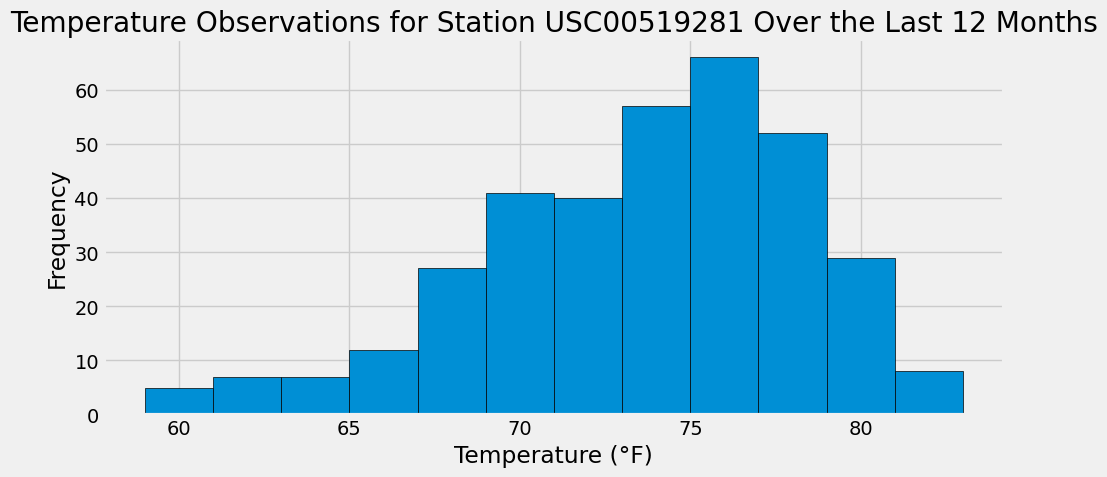

In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station_id = most_active_stations[0][0]  # Get the first station ID from the results

# Step 1: Calculate the date one year ago from the most recent date
most_recent_date = session.query(func.max(Measurement.date)).scalar()
one_year_ago = datetime.strptime(most_recent_date, '%Y-%m-%d') - timedelta(days=365)

# Step 2: Query the last 12 months of temperature observation data for this station
temperature_data = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station_id).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

# Step 3: Save the query results to a Pandas DataFrame
temperature_df = pd.DataFrame(temperature_data, columns=['tobs'])

# Step 4: Plot the results as a histogram
plt.figure(figsize=(10, 5))
plt.hist(temperature_df['tobs'], bins=12, edgecolor='black')
plt.title(f'Temperature Observations for Station {most_active_station_id} Over the Last 12 Months')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Close Session

In [19]:
# Close Session
session.close()